In [1]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
import gc
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, CuDNNLSTM, concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D, Dropout, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


## Loading and reading the dataset

In [2]:
df = pd.read_csv("train.csv")
print("Train shape : ",df.shape)


Train shape :  (1306122, 3)


In [3]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


## **EDA**

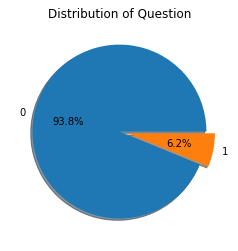

In [4]:
ax=df['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%' ,shadow=True)
ax.set_title('Distribution of Question')
ax.set_ylabel('')
plt.show()

In [0]:
X = df["question_text"].values
y = df['target'].values

### Making word cloud

In [0]:
insincere_questions = df.loc[df['target'] == 1].values

In [7]:
len(insincere_questions)

80810

In [8]:
insincere_questions[0][1]

'Has the United States become the largest dictatorship in the world?'

In [9]:
from nltk import FreqDist
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
word_tokens = [word_tokenize(question[1]) for question in insincere_questions]

#freq_dist = FreqDist([word for question in insincere_questions for word in question[1].split()])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
word_tokens[1][1]

'babies'

In [0]:
all_words = [word for question in word_tokens for word in question]

In [12]:
len(all_words)

1582702

In [0]:
without_stopwords = [w for w in all_words if not w in stop_words]

In [14]:
len(without_stopwords)

1017310

In [0]:
words_len = [w for w in without_stopwords if not len(w)<5]

In [16]:
len(words_len)

536765

In [0]:
freq_dist = FreqDist([word for word in words_len])

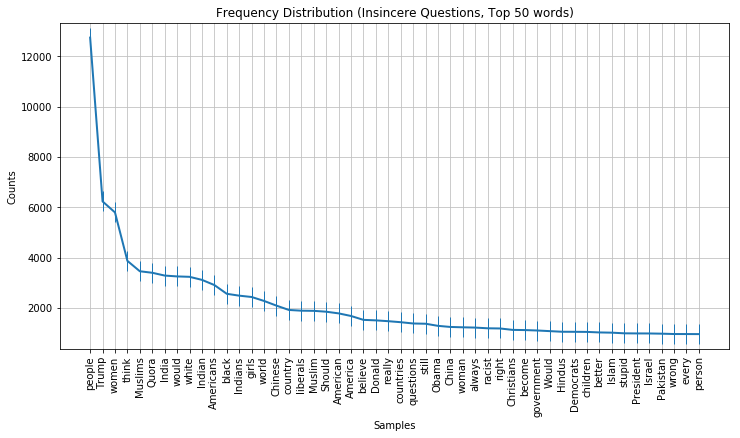

In [18]:
plt.figure(figsize=(12,6))
plt.title(f'Frequency Distribution (Insincere Questions, Top 50 words)')
freq_dist.plot(50, marker='|', markersize=20)
plt.show()

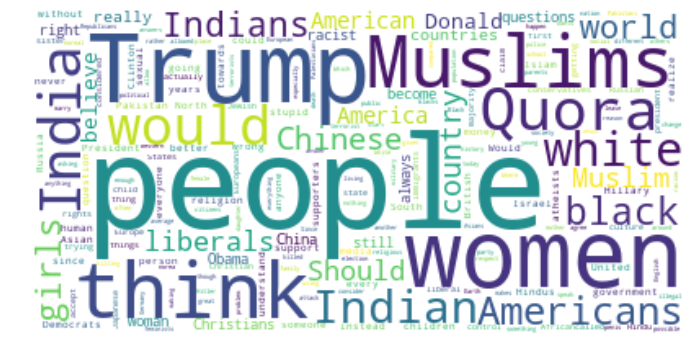

In [19]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='White').generate_from_frequencies(freq_dist)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Splitting dataset into train and test

In [0]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.25)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, stratify=train_y, test_size=0.1)

In [21]:
train_X[110]

'Which is the best free software to convert word document into video?'

In [22]:
print("Train shape : ",train_X.shape)
print("Validation shape : ",val_X.shape)
print("Test shape : ",test_X.shape)


Train shape :  (881631,)
Validation shape :  (97960,)
Test shape :  (326531,)


In [23]:
unique, counts = np.unique(train_y, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(val_y, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[     0 827085]
 [     1  54546]]
[[    0 91899]
 [    1  6061]]
[[     0 306328]
 [     1  20203]]


In [24]:
testdf = pd.DataFrame()
testdf['question'] = test_X

testdf['target'] = test_y
testdf.shape

(326531, 2)

## Tokenize the sentences

In [0]:
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use


In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 


In [0]:
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)

In [28]:
len(train_X)

881631

In [29]:
train_X[110]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         30,    3,    1,   33,  196,  254,    5, 1123,  402, 3095,  101,
        370], dtype=int32)

## **Undersampling**

In [30]:
from collections import Counter
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(train_X, train_y)
print(sorted(Counter(y_resampled).items()))

[(0, 54546), (1, 54546)]


In [31]:
train_X.shape

(881631, 100)

In [32]:
train_X[110]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         30,    3,    1,   33,  196,  254,    5, 1123,  402, 3095,  101,
        370], dtype=int32)

In [0]:
embed_size = 100 # how big is each word vector

S_DROPOUT = 0.4
DROPOUT = 0.1

In [0]:
def plotting(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()    

In [35]:
train_X.shape

(881631, 100)

In [36]:
unique, counts = np.unique(train_y, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(val_y, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[     0 827085]
 [     1  54546]]
[[    0 91899]
 [    1  6061]]
[[     0 306328]
 [     1  20203]]


## Glove Embeddings

In [0]:
from numpy import asarray
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
  values = line.split()
  word = values[0]
  coefs = asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

In [0]:
from numpy import zeros
# create a weight matrix for words in training docs
embedding_matrix = zeros((max_features, 100))
for word, i in tokenizer.word_index.items():
  if i >= max_features: continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

## **Utility Functions**

In [0]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

In [0]:
def getConfusionMatrix(y_test, y_pred):
  # Confusion matrix
  mat = confusion_matrix(y_test, y_pred)
  cm = pd.DataFrame(mat)
  TP = cm.iloc[1,1] # True Positive 
  TN = cm.iloc[0,0] # True Negative 
  FP = cm.iloc[0,1] # False Positive
  FN = cm.iloc[1,0] # False Negative

  print('Sensitivity: {:.2%}'.format(TP/(FN+TP)))
  print('Specificity: {:.2%}'.format(TN/(FP+TN)))
  
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
  plt.title('A confusion matrix showing the frequency of misclassifications by our classifier')
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  plt.show()

In [0]:
def getROCMetrics(y_test, y_prob_rain):
  fpr, tpr, thresholds = roc_curve(y_test,y_prob_rain[:,1])

  #ROC Curve
  fig,ax1 = plt.subplots(figsize=(9,6))
  ax1.plot(fpr, tpr,color='orange')
  ax1.legend(['ROC Curve'],loc=1)
  ax1.set_xlim([-0.005, 1.0])
  ax1.set_ylim([0,1])
  ax1.set_ylabel('True Positive Rate (Sensitivity)')
  ax1.set_xlabel('False Positive Rate \n(1 - Specificity)\n FP / (TN + FP)')
  ax1.set_title('ROC Curve for RainTomorrow\n')

#   plt.plot([0,1],[0,1],linestyle='--',color='teal')
#   plt.plot([0,1],[0.5,0.5],linestyle='--',color='red',linewidth=0.25)

#   #Threshold Curve
#   ax2 = plt.gca().twinx()
#   ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='black')
#   ax2.legend(['Threshold'],loc=4)
#   ax2.set_ylabel('Threshold',color='black')
#   ax2.set_ylim([0,1])
#   ax2.grid(False)
  
  plt.show()
  
  rf_auc = roc_auc_score(y_test,y_prob_rain[:,1])
  print('AUC Score:', rf_auc*100)
  return rf_auc*100

#Models

## Without pretrained embeddings

In [42]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)



x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          5000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          63744     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)  

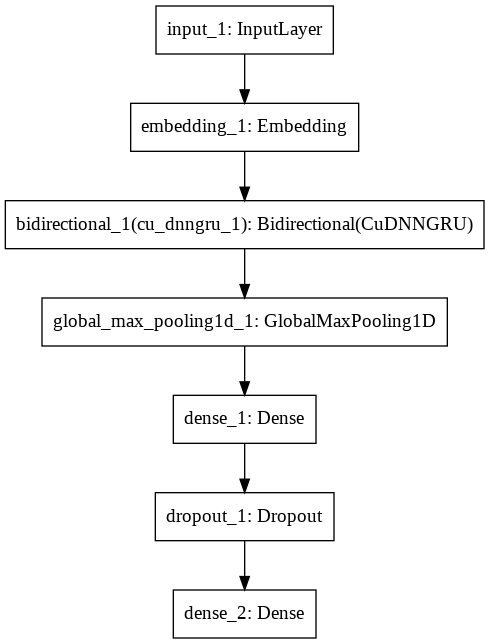

In [43]:
from keras.utils import  plot_model
from IPython.display import Image, display
model_name = 'Without pretrained embeddings'
plot_model(model, to_file = model_name +'-model.png', show_shapes=False)
Image(filename = model_name + '-model.png')

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 109092 samples, validate on 97960 samples
Epoch 1/5
109092/109092 [==============================] - 14s 130us/step - loss: 0.3789 - acc: 0.8458 - val_loss: 0.3276 - val_acc: 0.8626
Epoch 2/5
109092/109092 [==============================] - 8s 73us/step - loss: 0.2476 - acc: 0.9073 - val_loss: 0.3280 - val_acc: 0.8589
Epoch 3/5
109092/109092 [==============================] - 8s 73us/step - loss: 0.2128 - acc: 0.9227 - val_loss: 0.2982 - val_acc: 0.8742
Epoch 4/5
109092/109092 [==============================] - 8s 74us/step - loss: 0.1855 - acc: 0.9342 - val_loss: 0.3617 - val_acc: 0.8489
Epoch 5/5
109092/109092 [==============================] - 8s 74us/step - loss: 0.1583 - acc: 0.9461 - val_loss: 0.3930 - val_acc: 0.8452


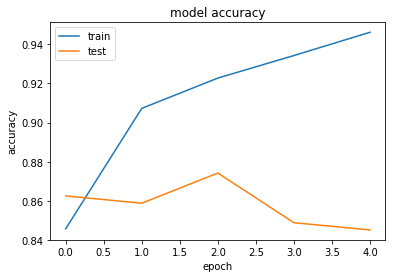

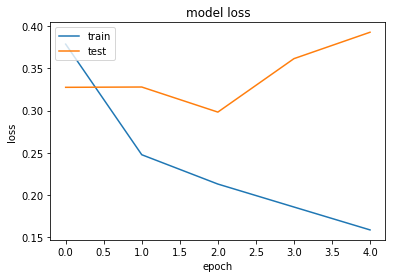

Test Accuracy: 84.483556


In [44]:
## Train the model 
history = model.fit(X_resampled, y_resampled, batch_size=512, epochs=5, validation_data=(val_X, val_y))
plotting(history)

loss, acc = model.evaluate(test_X, test_y, verbose=0)
print('Test Accuracy: %f' % (acc*100))

In [45]:
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)

97960/97960 [==============================] - 2s 18us/step


In [46]:

thresholds = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    res = metrics.f1_score(val_y, (pred_val_y > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)

F1 score at threshold 0.1 is 0.30764358108108103
F1 score at threshold 0.11 is 0.31347827258277433
F1 score at threshold 0.12 is 0.3189934618976979
F1 score at threshold 0.13 is 0.32381856775779244
F1 score at threshold 0.14 is 0.32826506297515035
F1 score at threshold 0.15 is 0.3323454090294363
F1 score at threshold 0.16 is 0.3361707089552239
F1 score at threshold 0.17 is 0.3397674281329319
F1 score at threshold 0.18 is 0.3435557149689144
F1 score at threshold 0.19 is 0.3473999455485979
F1 score at threshold 0.2 is 0.35081816791558346
F1 score at threshold 0.21 is 0.3541305960920109
F1 score at threshold 0.22 is 0.35704689599150186
F1 score at threshold 0.23 is 0.3598247217931339
F1 score at threshold 0.24 is 0.36269891788669634
F1 score at threshold 0.25 is 0.3653815286828674
F1 score at threshold 0.26 is 0.36804454083449323
F1 score at threshold 0.27 is 0.37099461048505633
F1 score at threshold 0.28 is 0.3735054840090906
F1 score at threshold 0.29 is 0.37577608818353864
F1 score at 

In [47]:
pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)
pred_test_y =  (pred_test_y > best_thresh).astype(int)

unique, counts = np.unique(pred_test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

326531/326531 [==============================] - 6s 17us/step
[[     0 259224]
 [     1  67307]]


Sensitivity: 91.18%
Specificity: 84.04%


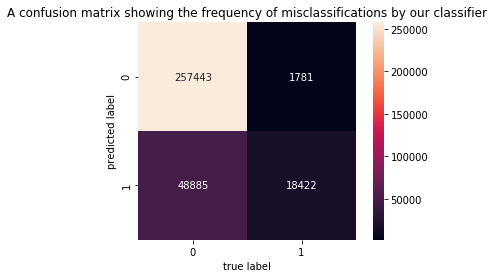

In [48]:
getConfusionMatrix(test_y, pred_test_y)

In [49]:
print(f1_score(pred_test_y, test_y, average="macro"))
print(precision_score(pred_test_y, test_y, average="macro"))
print(recall_score(pred_test_y, test_y, average="macro"))

0.6657196788380089
0.8761304653803434
0.6334152975541234


In [50]:
testdf['predicted target'] = pred_test_y
testdf.head()

,question,target,predicted target
0,My mother in law and wife form a tag team afte...,1,1
1,How much was your salary while attending Army ...,0,0
2,Is there a distinction between the American na...,0,0
3,How much do learning and development consultan...,0,0
4,I have two full weeks to travel to Asia Pacifi...,0,0


## Using GloVe Embeddings

In [51]:
embed_size

100

In [52]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 100)          5000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          63744     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

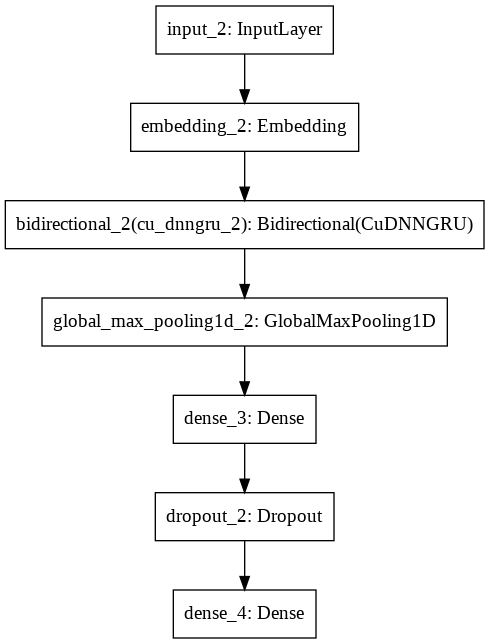

In [53]:
from keras.utils import  plot_model
from IPython.display import Image, display
model_name = 'Using Glove Embeddings'
plot_model(model, to_file = model_name +'-model.png', show_shapes=False)
Image(filename = model_name + '-model.png')

Train on 109092 samples, validate on 97960 samples
Epoch 1/5
109092/109092 [==============================] - 9s 84us/step - loss: 0.3590 - acc: 0.8510 - val_loss: 0.3472 - val_acc: 0.8512
Epoch 2/5
109092/109092 [==============================] - 8s 75us/step - loss: 0.2652 - acc: 0.8984 - val_loss: 0.2691 - val_acc: 0.8897
Epoch 3/5
109092/109092 [==============================] - 8s 74us/step - loss: 0.2315 - acc: 0.9128 - val_loss: 0.2646 - val_acc: 0.8904
Epoch 4/5
109092/109092 [==============================] - 8s 74us/step - loss: 0.2020 - acc: 0.9261 - val_loss: 0.3587 - val_acc: 0.8455
Epoch 5/5
109092/109092 [==============================] - 8s 75us/step - loss: 0.1763 - acc: 0.9369 - val_loss: 0.2672 - val_acc: 0.8953


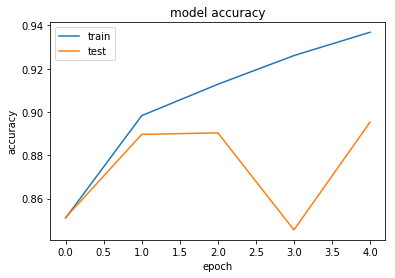

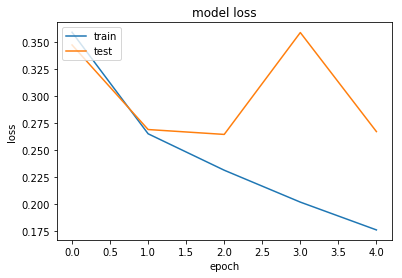

Test Accuracy: 89.498087


In [54]:
history = model.fit(X_resampled, y_resampled, batch_size=512, epochs=5, validation_data=(val_X, val_y))
plotting(history)

loss, acc = model.evaluate(test_X, test_y, verbose=0)
print('Test Accuracy: %f' % (acc*100))

In [55]:
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)


thresholds = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    res = metrics.f1_score(val_y, (pred_val_y > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)


97960/97960 [==============================] - 2s 18us/step
F1 score at threshold 0.1 is 0.35829074564374114
F1 score at threshold 0.11 is 0.3661634466891488
F1 score at threshold 0.12 is 0.37336596046107284
F1 score at threshold 0.13 is 0.38022663820003283
F1 score at threshold 0.14 is 0.3863438774827794
F1 score at threshold 0.15 is 0.39251063829787236
F1 score at threshold 0.16 is 0.3976761878414828
F1 score at threshold 0.17 is 0.40307627475769064
F1 score at threshold 0.18 is 0.40824183658919155
F1 score at threshold 0.19 is 0.4126043435839988
F1 score at threshold 0.2 is 0.4168374816983895
F1 score at threshold 0.21 is 0.421505376344086
F1 score at threshold 0.22 is 0.4263612467142321
F1 score at threshold 0.23 is 0.4306172839506173
F1 score at threshold 0.24 is 0.4340781693926131
F1 score at threshold 0.25 is 0.4376260667183864
F1 score at threshold 0.26 is 0.4407974619090517
F1 score at threshold 0.27 is 0.44426871219010716
F1 score at threshold 0.28 is 0.4473778664007977
F1 sc

In [56]:
pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)
pred_test_y = (pred_test_y > best_thresh).astype(int)

unique, counts = np.unique(pred_test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

326531/326531 [==============================] - 6s 17us/step
[[     0 276236]
 [     1  50295]]


Sensitivity: 89.61%
Specificity: 89.49%


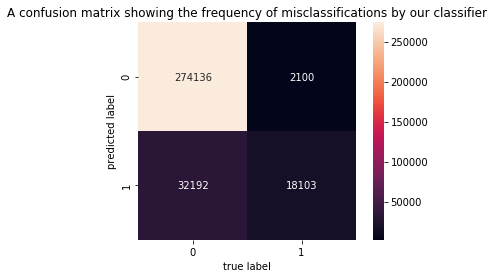

In [57]:
getConfusionMatrix(test_y, pred_test_y)

In [58]:
print(f1_score(pred_test_y, test_y, average="macro"))
print(precision_score(pred_test_y, test_y, average="macro"))
print(recall_score(pred_test_y, test_y, average="macro"))

0.7273554671866271
0.8954825362041472
0.6761670900804269


In [59]:
testdf['predicted target - GloVe'] = pred_test_y
testdf.head()

,question,target,predicted target,predicted target - GloVe
0,My mother in law and wife form a tag team afte...,1,1,0
1,How much was your salary while attending Army ...,0,0,0
2,Is there a distinction between the American na...,0,0,0
3,How much do learning and development consultan...,0,0,0
4,I have two full weeks to travel to Asia Pacifi...,0,0,0


## Using Wiki News FastText Embeddings

In [60]:
import os
from os.path import join, exists
from keras.utils.data_utils import get_file

wiki_url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip'
wiki_filename = 'wiki-news-300d-1M.vec.zip'
wiki_loc = join(wiki_filename)

if not exists(wiki_loc):
    print('Download %s' % wiki_filename)
    get_file(wiki_filename, wiki_url, cache_dir='.', extract=True)

Download wiki-news-300d-1M.vec.zip
681811968/681808098 [==============================] - 58s 0us/step


In [61]:
EMBEDDING_FILE = 'datasets/wiki-news-300d-1M.vec'

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [0]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


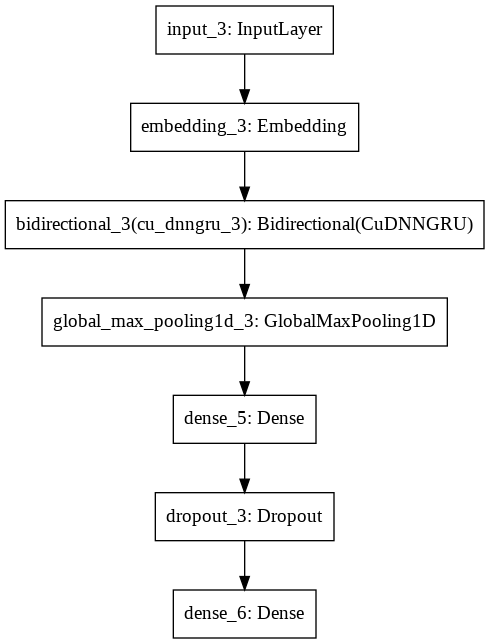

In [63]:
from keras.utils import  plot_model
from IPython.display import Image, display
model_name = 'Using Wiki News FastText Embeddings'
plot_model(model, to_file = model_name +'-model.png', show_shapes=False)
Image(filename = model_name + '-model.png')

Train on 109092 samples, validate on 97960 samples
Epoch 1/5
109092/109092 [==============================] - 14s 125us/step - loss: 0.3221 - acc: 0.8735 - val_loss: 0.2570 - val_acc: 0.8915
Epoch 2/5
109092/109092 [==============================] - 13s 115us/step - loss: 0.2294 - acc: 0.9142 - val_loss: 0.2747 - val_acc: 0.8880
Epoch 3/5
109092/109092 [==============================] - 12s 114us/step - loss: 0.1887 - acc: 0.9314 - val_loss: 0.2986 - val_acc: 0.8774
Epoch 4/5
109092/109092 [==============================] - 12s 113us/step - loss: 0.1496 - acc: 0.9473 - val_loss: 0.4248 - val_acc: 0.8370
Epoch 5/5
109092/109092 [==============================] - 12s 112us/step - loss: 0.1121 - acc: 0.9612 - val_loss: 0.4288 - val_acc: 0.8583


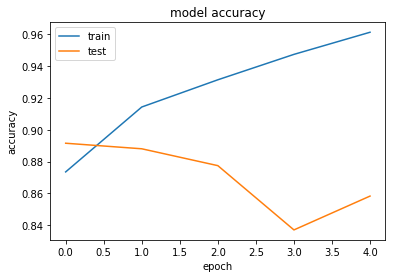

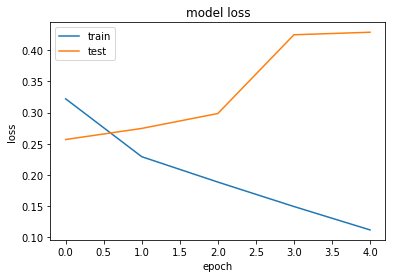

Test Accuracy: 85.842692


In [64]:
history = model.fit(X_resampled, y_resampled, batch_size=512, epochs=5, validation_data=(val_X, val_y))
plotting(history)

loss, acc = model.evaluate(test_X, test_y, verbose=0)
print('Test Accuracy: %f' % (acc*100))

In [65]:
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)


thresholds = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    res = metrics.f1_score(val_y, (pred_val_y > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)

97960/97960 [==============================] - 3s 27us/step
F1 score at threshold 0.1 is 0.33231174634090455
F1 score at threshold 0.11 is 0.3373613254520572
F1 score at threshold 0.12 is 0.3422858495030762
F1 score at threshold 0.13 is 0.34655632514767176
F1 score at threshold 0.14 is 0.35070024607345746
F1 score at threshold 0.15 is 0.3537548799606529
F1 score at threshold 0.16 is 0.3576360808709176
F1 score at threshold 0.17 is 0.36139423681892535
F1 score at threshold 0.18 is 0.3651510333863275
F1 score at threshold 0.19 is 0.3682182985553772
F1 score at threshold 0.2 is 0.3714471122647632
F1 score at threshold 0.21 is 0.37454164484023045
F1 score at threshold 0.22 is 0.37750181650042935
F1 score at threshold 0.23 is 0.3801724424914278
F1 score at threshold 0.24 is 0.38321462169063303
F1 score at threshold 0.25 is 0.3859839371039344
F1 score at threshold 0.26 is 0.3880810976858489
F1 score at threshold 0.27 is 0.3903311212735962
F1 score at threshold 0.28 is 0.39286703601108036
F1 

In [66]:
pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)
pred_test_y = (pred_test_y > best_thresh).astype(int)

unique, counts = np.unique(pred_test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

326531/326531 [==============================] - 8s 25us/step
[[     0 263594]
 [     1  62937]]


In [67]:
pred_test_y

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [69]:
test_y

array([1, 0, 0, ..., 0, 0, 0])

In [0]:
p_y = [i[0] for i in pred_test_y]

Sensitivity: 91.35%
Specificity: 85.48%


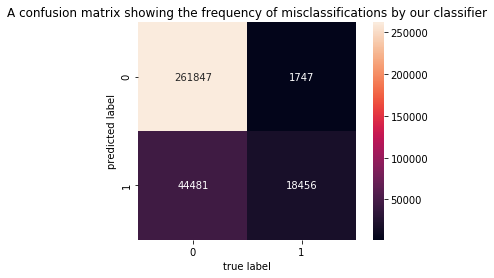

In [75]:

getConfusionMatrix(test_y, p_y)

In [76]:
print(f1_score(pred_test_y, test_y, average="macro"))
print(precision_score(pred_test_y, test_y, average="macro"))
print(recall_score(pred_test_y, test_y, average="macro"))

0.681430582843044
0.8841602978165499
0.6433090049326888


In [77]:
testdf['predicted target - Wiki'] = pred_test_y
testdf.head()

,question,target,predicted target,predicted target - GloVe,predicted target - Wiki
0,My mother in law and wife form a tag team afte...,1,1,0,1
1,How much was your salary while attending Army ...,0,0,0,0
2,Is there a distinction between the American na...,0,0,0,0
3,How much do learning and development consultan...,0,0,0,0
4,I have two full weeks to travel to Asia Pacifi...,0,0,0,0


In [0]:
testdf.to_csv("Output.csv", encoding='utf-8', index=False)
